In [1]:
import os
import sys

chrome_driver_path = os.path.join("/", 'home', 'morlov', 'chromedriver')
# os.path.join("/", 'usr', 'local', 'bin', 'chromedriver') local
os.environ["PATH"] += os.pathsep + chrome_driver_path
os.environ["MINIWOB_BASE_URL"] = "file:///mnt/morlov/miniwob-plusplus/html/"

In [2]:
from miniwob.environment import MiniWoBEnvironment
from miniwob.action import  MiniWoBCoordClick
from miniwob.screenshot import pil_to_numpy_array

task_name = 'click-button'
base_url = os.environ.get('MINIWOB_BASE_URL')
env = MiniWoBEnvironment(task_name, seeds=[1, 2, 3], num_instances=3, base_url=base_url, headless=True)
print('BASE URL:', base_url)

BASE URL: file:///mnt/morlov/miniwob-plusplus/html/


In [3]:
states = env.reset(record_screenshots=True)

In [4]:
states

[MiniWoBState(utterance: 'Click on the "Ok" button.'),
 MiniWoBState(utterance: 'Click on the "ok" button.'),
 MiniWoBState(utterance: 'Click on the "no" button.')]

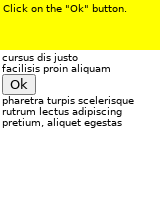

In [5]:
states[0].screenshot

In [6]:
img = pil_to_numpy_array(states[0].screenshot)
img.shape

(210, 160, 3)

In [7]:
states[0].dom.visualize()

"- [1] body @ (0, 0) classes=[NO_CLASS] children=1\n  |- [2] div @ (0, 0) classes=[NO_CLASS] children=1\n     |- [3] div @ (0, 50) classes=[NO_CLASS] children=6\n        |- [4] div @ (2, 52) text='cursus dis justo' classes=[NO_CLASS]\n        |- [5] div @ (2, 63) text='facilisis proin aliq...' classes=[NO_CLASS]\n        |- [6] button @ (2, 74) text='Ok' classes=[NO_CLASS]\n        |- [7] div @ (2, 95) text='pharetra turpis scel...' classes=[NO_CLASS]\n        |- [8] div @ (2, 106) text='rutrum lectus adipis...' classes=[NO_CLASS]\n        |- [9] div @ (2, 117) text='pretium, aliquet ege...' classes=[NO_CLASS]"

In [8]:
states[0].tokens

['Click', 'on', 'the', '"', 'Ok', '"', 'button', '.']

In [9]:
env.close()

# Set device

In [10]:
device = 'cuda'

# Gym miniwob wrapper

In [17]:
import gym
import torch
import numpy as np

from miniwob.action import MiniWoBElementClick, MiniWoBCoordClick
from transformers import BertTokenizer, BertModel, BertConfig


class MiniWobClickButtonWrapper(gym.Wrapper):
    
    def __init__(self, env):      
        super().__init__(env)
        self.env = env
        bert_model = 'bert-base-cased'
        code_bert_model = "microsoft/codebert-base"
        self.tokenizer = BertTokenizer.from_pretrained(bert_model)
        self.n_tokens_goal = 8
        self.n_tokens_dom = 128
        self.dom_tokenizer = RobertaTokenizer.from_pretrained(code_bert_model)
        
        self.observation_space = gym.spaces.Dict({"goal_state": gym.spaces.Box(0, 
                                                                              self.tokenizer.vocab_size, 
                                                                              (self.n_tokens_goal, ),
                                                                              dtype=np.int64), 
                                                  "dom_state": gym.spaces.Box(0,
                                                                        self.dom_tokenizer.vocab_size,
                                                                        (self.n_tokens_dom, ), 
                                                                              dtype=np.int64),
                                                  "img_state": gym.spaces.Box(0, 255, (210, 160, 3), dtype=np.uint8)})
        

        self.h, self.w = 210, 160
        self.grid_step = 10
        n_actions = int(self.h/self.grid_step+1) * int(self.w/self.grid_step+1)
        self.action_space = gym.spaces.Discrete(n_actions)
        
    def _ob_to_token(self, ob):
        if ob is None:
            return torch.zeros(1, self.n_tokens_goal)
        else: 
            return self.tokenizer(ob.tokens,  
                                  padding='max_length', 
                                  max_length = self.n_tokens_goal, truncation=True,          
                                  return_tensors="pt",
                                  is_split_into_words=True)['input_ids']
        
    def _ob_dom_to_token(self, ob):
        if ob is None:
            return torch.zeros(1, self.n_tokens_dom)
        else: 
            dom = self.dom_tokenizer.tokenize(obs.dom.visualize())[:16]
            dom_str = "website DOM-tree"
            dom_str_tokens = self.dom_tokenizer.tokenize(dom_str)
            dom = [self.dom_tokenizer.cls_token] + dom_str_tokens + [self.dom_tokenizer.sep_token] \
                  + dom + [self.dom_tokenizer.sep_token] + [self.dom_tokenizer.pad_token] * self.n_tokens_dom
            dom = self.dom_tokenizer.convert_tokens_to_ids(dom[:self.n_tokens_dom])
            dom = torch.tensor(dom, dtype=torch.int64).unsqueeze(0)
            return dom
            
    def _ob_to_image(self, ob):
        if ob is None:
            return torch.zeros(1, self.h, self.w, 3)
        else:
            return torch.tensor(pil_to_numpy_array(ob.screenshot)).unsqueeze(0)
        
    
    def _to_miniwob_actions(self, actions):
        
        n_x = int(self.w/self.grid_step + 1)        
        actions = actions.squeeze()
        miniwob_actions = []
        
        for i in range(self.num_instances):
            if self.instances[i].get_metadata()['done']:
                miniwob_actions.append(None)
            else:
                k = actions[i].item()
                x, y = k%n_x * self.grid_step, int(k/n_x) * self.grid_step
                miniwob_actions.append(MiniWoBCoordClick(x, y))
        return miniwob_actions
        
    
    def observation(self, obs):
            
        goals = torch.cat([self._ob_to_token(ob) for ob in obs], dim=0).to(device)
        doms = torch.cat([self._ob_dom_to_token(ob) for ob in obs], dim=0).to(device)
        imgs = torch.cat([self._ob_to_image(ob) for ob in obs], dim=0).to(device)
        return {"img_state": imgs, 'dom_state': dom, 'goal_state': goals}
    
    def reset(self):
        return self.observation(self.env.reset(record_screenshots=True))
    
            
    
    def step(self, actions):
        
        miniwob_actions = self._to_miniwob_actions(actions)
        obs, rewards, dones, infos = self.env.step(miniwob_actions)        
        obs = self.observation(obs)
        
        for instance in self.env.instances:
            if instance.get_metadata()['done']:
                instance.begin_task()
        
        return obs, torch.tensor([rewards]).T, torch.tensor([dones]).T, infos['n']
        
class EpisodeInfoWrapper(gym.Wrapper):
    
    def __init__(self, env, n):
        super(EpisodeInfoWrapper, self).__init__(env)
        self.episode_reward = np.zeros(n)
        self.episode_steps = np.zeros(n)
        self.n = n

    def reset(self):
        self.episode_reward = np.zeros(self.n)
        self.episode_steps = np.zeros(self.n)
        return self.env.reset()

    def step(self, actions):
        states, rewards, dones, infos = self.env.step(actions)
        
        for i, done in enumerate(dones):
            if done:
                self.episode_reward[i] = rewards[i]
                self.episode_steps[i] += 1
                infos[i]['episode'] = {'r': self.episode_reward[i], 'steps': self.episode_steps[i]}
                
        return states, rewards, dones, infos

In [18]:
def get_envs(n, **kwargs):
    env = MiniWoBEnvironment(task_name, seeds=range(n), num_instances=n, base_url=base_url, **kwargs)
    env = MiniWobClickButtonWrapper(env)
    return EpisodeInfoWrapper(env, n)

# Bert encoder

In [19]:
from transformers import BertTokenizer, BertModel, BertConfig
from torch import nn
import torch

class BertEncoder(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        bert_model = 'bert-base-cased'
        self.bert_encoder = BertModel.from_pretrained(bert_model).to(device)
        self.embed_dim = 768
        output_size = 100
        self.lstm = nn.LSTM(input_size=self.embed_dim, 
                            hidden_size=output_size, 
                            num_layers=2)
        self.hidden_size = 128
        in_size = output_size
        out_size = self.hidden_size
        self.fc = nn.Sequential(nn.Linear(in_size, out_size), nn.ReLU())
        self.output_size = out_size
   
    def forward(self, input_ids):
        """
        Encode batch of tokens
        
        """
        with torch.no_grad():
            embeds = self.bert_encoder(input_ids.long()).last_hidden_state
        embeds = embeds.permute([1, 0, 2])
            
        output, _ = self.lstm(embeds)
        return self.fc(output[-1])

# Resnet Encoder

In [20]:
import torchvision.models as zoo_models

class ResNetEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = zoo_models.resnet34(pretrained=True)
        self.output_size = 32
        self.resnet = nn.Sequential(*list(resnet.children())[:-1])
        in_size, out_size = 512, self.output_size
        self.fc = nn.Sequential(nn.Linear(in_size, out_size), nn.ReLU())

    def forward(self, x):
        x = x.permute(0, 3, 1, 2)
        with torch.no_grad():
            encoded = self.resnet(x).reshape(x.shape[0], -1)
        return self.fc(encoded)

# CNN encoder

In [21]:
class Permute(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.dims = args

    def forward(self, x):
        return x.permute(self.dims)

class SimpleCNN(nn.Module):
    def __init__(self, h, w, conf):
        super().__init__()
        conv_layers = [Permute(0, 3, 1, 2)]
        cnn_output_h, cnn_output_w = h, w
        cur_channels = 3
        conv_params = zip(
            conf['n_channels'],
            conf['kernel_sizes'],
            conf['max_pools'] if conf.get('max_pools', False) else [1] * len(conf['n_channels']),
            conf['strides'] if conf.get('strides', False) else [1] * len(conf['n_channels'])
        )
        for n_channels, kernel_size, max_pool, stride in conv_params:
            conv_layers.append(nn.Conv2d(cur_channels, n_channels, kernel_size, stride))
            conv_layers.append(nn.ReLU(inplace=True))
            cnn_output_h += -1 * kernel_size + stride
            cnn_output_w += -1 * kernel_size + stride
            cnn_output_h //= stride
            cnn_output_w //= stride
            cur_channels = n_channels
            if max_pool > 1:
                conv_layers.append(nn.MaxPool2d(max_pool, max_pool))
                cnn_output_h //= max_pool
                cnn_output_w //= max_pool
        self.conv_net = nn.Sequential(*conv_layers)
        output_size = cur_channels * cnn_output_h * cnn_output_w

        hidden_layers_sizes = list(conf.get('hidden_layers_sizes', []))
        if hidden_layers_sizes:
            fc_layers = []
            layers_size = [output_size] + hidden_layers_sizes
            for size_in, size_out in zip(layers_size[:-1], layers_size[1:]):
                fc_layers.append(nn.Linear(size_in, size_out))
                fc_layers.append(nn.ReLU())
            self.fc = nn.Sequential(*fc_layers)
            output_size = layers_size[-1]
        else:
            self.fc = None

        self.output_size = output_size

    def forward(self, x):
        res = self.conv_net(x.float() / 255.).reshape(x.shape[0], -1)
        if self.fc is not None:
            res = self.fc(res)
        return res

# Dom encoder

In [16]:
class DomEncoder(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.bert_encoder = RobertaModel.from_pretrained("microsoft/codebert-base")
        self.embed_dim = 768
        self.output_size = 100
        self.lstm = nn.LSTM(input_size=self.embed_dim,
                            hidden_size=self.output_size, 
                            num_layers=2)
        self.hidden_size = 128
        in_size = output_size
        out_size = self.hidden_size
        self.fc = nn.Sequential(nn.Linear(in_size, out_size), nn.ReLU())
        self.output_size = out_size
        
   
    def forward(self, input_ids):
        """
        Encode batch of tokens
        
        """
        with torch.no_grad():
            embeds = self.bert_encoder(input_ids.long()).last_hidden_state
        embeds = embeds.permute([1, 0, 2])
            
        output, _ = self.lstm(embeds)
        return self.fc(output[-1])


class Encoder(nn.Module):
    def __init__(self, img, dom):
        super(Encoder, self).__init__()
        self.img_encoder = img
        self.dom_encoder = dom
        self.output_size = self.dom_encoder.output_size + self.img_encoder.output_size
    
    def forward(self, ob):
        img_out = self.img_encoder(ob['img'])
        dom_out = self.dom_encoder(ob['dom'])
        out = torch.cat([img_out, dom_out], dim=-1)
        return out

# Init encoders

In [16]:
from rllr.models.encoders import GoalStateEncoder # , SimpleCNN

conf = {
    "n_channels": [32, 32, 32, 32, 32, 32],
    "kernel_sizes": [4, 4, 4, 4, 4, 4],
    "strides": [4, 2, 1, 1, 1, 1],
    "hidden_layers_sizes": [128]
}

state_encoder = SimpleCNN(h=210, w=160, conf=conf).to(device)
goal_encoder = BertEncoder().to(device)
dom_encoder = DomEncoder().to(device)
state_encoder = Encoder(img_encoder, dom_encoder).to(device)
goal_encoder = BertEncoder().to(device)
encoder = GoalStateEncoder(state_encoder, goal_encoder)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Train agent

In [17]:
n_instances = 16
envs = get_envs(n_instances, headless=True)

In [18]:
from rllr.algo import PPO
from rllr.models.ppo import ActorCriticNetwork

hidden_size = 32
policy = ActorCriticNetwork(envs.action_space, encoder, encoder, hidden_size, hidden_size).to(device)

agent_conf = {
        "clip_param": 0.2,
        "ppo_epoch": 4,
        "num_mini_batch": 4,
        "value_loss_coef": 0.5,
        "entropy_coef": 0.01,
        "lr": 0.001,
        "eps": 1e-5,
        "max_grad_norm": 0.5,
}


agent = PPO(policy, **agent_conf)

In [ ]:
agent = torch.load("miniwob_click_button.p")

In [19]:
from rllr.utils.training import train_ppo

train_conf = {
    "agent.lr": 0.001,
    "agent.device": device,
    "agent.gamma": 0.99,
    "agent.gae_lambda": 0.95,
    "training.n_env_steps": 100000,
    "training.n_steps": 100,
    "training.n_processes": n_instances,
    "training.verbose": 5,
    "outputs.path": "miniwob_click_button.p"
}


train_ppo(envs, agent, train_conf)

  0%|          | 0/62 [00:00<?, ?it/s]

Updates 0, num timesteps 1600, FPS 26 
Last 10 training episodes: mean/median reward -0.33/-0.49, min/max reward -1.00/0.90
dist_entropy 5.92, value_loss 0.09, action_loss -0.01


  8%|▊         | 5/62 [05:01<57:13, 60.23s/it]

Updates 5, num timesteps 9600, FPS 26 
Last 10 training episodes: mean/median reward 0.03/0.36, min/max reward -1.00/0.96
dist_entropy 5.84, value_loss 0.10, action_loss -0.01


 16%|█▌        | 10/62 [10:02<52:09, 60.17s/it]WARNING:root:Cannot call CoordClick(coords: (110, 20)) on instance 2, which is already done


Updates 10, num timesteps 17600, FPS 26 
Last 10 training episodes: mean/median reward -0.81/-1.00, min/max reward -1.00/0.90
dist_entropy 5.76, value_loss 0.10, action_loss -0.01


 24%|██▍       | 15/62 [15:03<47:04, 60.11s/it]

Updates 15, num timesteps 25600, FPS 26 
Last 10 training episodes: mean/median reward -0.21/-0.43, min/max reward -1.00/0.90
dist_entropy 5.66, value_loss 0.11, action_loss -0.01


 32%|███▏      | 20/62 [20:05<42:08, 60.21s/it]

Updates 20, num timesteps 33600, FPS 26 
Last 10 training episodes: mean/median reward 0.14/0.40, min/max reward -1.00/0.91
dist_entropy 5.47, value_loss 0.10, action_loss -0.01


 40%|████      | 25/62 [25:06<37:06, 60.16s/it]

Updates 25, num timesteps 41600, FPS 26 
Last 10 training episodes: mean/median reward -0.05/0.46, min/max reward -1.00/0.77
dist_entropy 5.47, value_loss 0.10, action_loss -0.01


 48%|████▊     | 30/62 [30:09<32:15, 60.49s/it]

Updates 30, num timesteps 49600, FPS 26 
Last 10 training episodes: mean/median reward -0.38/-1.00, min/max reward -1.00/0.90
dist_entropy 5.63, value_loss 0.08, action_loss -0.01


 56%|█████▋    | 35/62 [35:15<27:27, 61.03s/it]

Updates 35, num timesteps 57600, FPS 26 
Last 10 training episodes: mean/median reward -0.13/-0.33, min/max reward -1.00/0.96
dist_entropy 5.64, value_loss 0.10, action_loss -0.01


 65%|██████▍   | 40/62 [40:19<22:16, 60.77s/it]

Updates 40, num timesteps 65600, FPS 26 
Last 10 training episodes: mean/median reward 0.10/0.73, min/max reward -1.00/0.96
dist_entropy 5.60, value_loss 0.12, action_loss -0.01


 73%|███████▎  | 45/62 [45:23<17:11, 60.68s/it]

Updates 45, num timesteps 73600, FPS 26 
Last 10 training episodes: mean/median reward -0.19/-0.49, min/max reward -1.00/0.96
dist_entropy 5.51, value_loss 0.11, action_loss -0.01


 81%|████████  | 50/62 [50:26<12:07, 60.61s/it]WARNING:root:Cannot call CoordClick(coords: (140, 180)) on instance 1, which is already done


Updates 50, num timesteps 81600, FPS 26 
Last 10 training episodes: mean/median reward -0.02/0.31, min/max reward -1.00/0.96
dist_entropy 5.55, value_loss 0.12, action_loss -0.00


 89%|████████▊ | 55/62 [55:28<07:01, 60.25s/it]WARNING:root:Cannot call CoordClick(coords: (50, 70)) on instance 2, which is already done


Updates 55, num timesteps 89600, FPS 26 
Last 10 training episodes: mean/median reward -0.65/-1.00, min/max reward -1.00/0.30
dist_entropy 5.57, value_loss 0.10, action_loss -0.00


 97%|█████████▋| 60/62 [1:00:30<02:00, 60.40s/it]

Updates 60, num timesteps 97600, FPS 26 
Last 10 training episodes: mean/median reward -0.09/-0.16, min/max reward -1.00/0.90
dist_entropy 5.54, value_loss 0.13, action_loss -0.00


100%|██████████| 62/62 [1:02:31<00:00, 60.52s/it]
